In [1]:
import sys

sys.path.append("../")

In [2]:
import torch
import pandas as pd
import numpy as np
import wandb
import igraph as ig

import matplotlib.pyplot as plt

from full_pipeline_main import generate_dataset
from models import SDCI
from utils import create_intervention_dataset, subset_interventions

In [25]:
seed = 0
n, d = 100, 75
n_edges_per_d = 5
frac_interventions = 1.0

def scale_fn(depth, plateau_depth = 17, slope = 7):
    return (max(1, plateau_depth - depth) / plateau_depth) * slope

X_df, B_true, wandb_config_dict = generate_dataset(
    n, d, seed, frac_interventions, n_edges_per_d=n_edges_per_d, scale=scale_fn
)
X_obs = X_df[X_df["perturbation_label"] == "obs"].loc[:, np.arange(d)].to_numpy()
X_sub_df = subset_interventions(
    X_df, d, maintain_dataset_size=True
)

Text(0.5, 0, 'Topological rank')

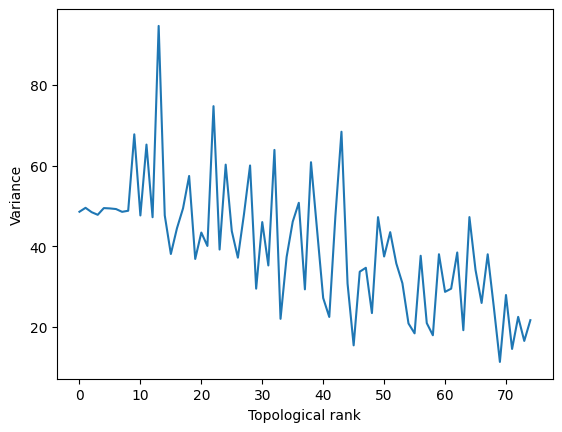

In [26]:
G = ig.Graph.Adjacency(B_true.tolist())
ordered_vertices = G.topological_sorting()
plt.plot(X_obs.var(axis=0)[ordered_vertices])
plt.ylabel("Variance")
plt.xlabel("Topological rank")

Text(0, 0.5, 'Variance(downstream_gene) - Variance(upstream_gene)')

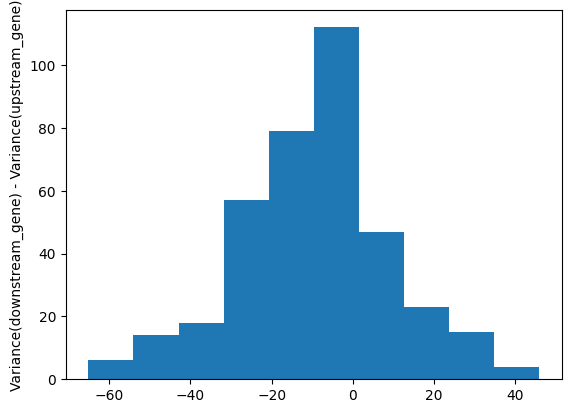

In [27]:
variances = X_obs.var(axis=0)
var_diffs = []
for i, j in zip(*np.where(B_true)):
    var_diffs.append(variances[j] - variances[i])
plt.hist(var_diffs)
plt.ylabel("Variance(downstream_gene) - Variance(upstream_gene)")

In [28]:
def run_sdci(): 
    wandb.init()
    mv_flavor = wandb.config.mv_flavor
    s1_alpha = wandb.config.s1_alpha
    s2_alpha = wandb.config.s2_alpha
    s1_beta = wandb.config.s1_beta
    s2_beta = wandb.config.s2_beta
    max_gamma = wandb.config.max_gamma
    
    dataset = create_intervention_dataset(X_sub_df, regime_format=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device}")
    model = SDCI(model_variance_flavor=mv_flavor)
    model.train(
        dataset,
        B_true=B_true,
        device=device,
        log_wandb=True,
        verbose=False,
        stage1_kwargs={"n_epochs": 1000, "alpha": s1_alpha, "beta": s1_beta},
        stage2_kwargs={"n_epochs": 1000, "alpha": s2_alpha, "beta": s2_beta, "max_gamma": max_gamma}
    )

In [29]:
sweep_configuration = {
    "method" : "bayes",
    "name": "sdci_new_sim_sweep",
    "metric": {
        "goal": "minimize",
        "name": "shd",
    },
    "parameters": {
        "s1_alpha": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "s2_alpha": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "s1_beta": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "s2_beta": {"max": 1e-1, "min": 1e-5, "distribution": "log_uniform_values"},
        "max_gamma": {"max": 1000, "min": 100, "distribution": "log_uniform_values"},
        "mv_flavor": {"values": ["unit", "parameter", "nn"]},
    },
    "early_terminate": {
        "type": "hyperband",
        "min_iter": 11,
    }
}

In [ ]:
wandb.login()

sweep_id = wandb.sweep(sweep=sweep_configuration, project="SDCI_new_hard_7_slope_sim_sweep")
wandb.agent(sweep_id, function=run_sdci)

wandb: Currently logged in as: justinhong (azizi-causal-perturb). Use `wandb login --relogin` to force relogin
